<a href="https://colab.research.google.com/github/Mechanics-Mechatronics-and-Robotics/CV-2025/blob/main/Lab_1_Feature_Extraction_and_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab. \#1. Feature Extraction and Machine Learning

## Problem Statement

The lab deals with comparison of two approaches to machine learning (ML) and computer vision (CV). The first approach is processing of hand-designed features, e.g. geometric features of objects in images, with an ML classification model. The second approach is using of the ML model for both, the automatic feature extraction and the following classification.

The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples.

The hand-designed features can be extracted with standart tools in [scikit-learn](https://scikit-learn.org/1.5/modules/feature_extraction.html)

## Tasks and Requirements
* Check the [Linghtning framework](https://lightning.ai/docs/pytorch/stable/) (Level Up, Core API, Optional API section of the manual)
* Check the [ClearML](https://clear.ml/docs/latest/docs/integrations/pytorch_lightning/)
* Fill the table in the Results section and fill the Conclusion section

Bonus

* apply a t-SNE model to visualize both, the original images dataset, and the designed table dataset with hand-extracted features from the images

# Preparation of computational models

## Import and Install Libraries

In [ ]:
!pip install pytorch-lightning clearml

In [ ]:
#Pytorch modules
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
#sklearn
from sklearn.metrics import confusion_matrix
#Numpy
import numpy as np
#Pandas
import pandas as pd
#Lightning & logging
import pytorch_lightning as pl
from pytorch_lightning import Trainer
#Data observation
import os
from pathlib import Path
#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
#Logging
from clearml import Task

## Set the Model

### Simulation Settings

Check the current directory

In [ ]:
os.getcwd() #returns the current working directory

'/content'

In [ ]:
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models")
print(f'CHECKPOINT_PATH: {CHECKPOINT_PATH}')

os.makedirs(CHECKPOINT_PATH, exist_ok=True)

Set the reproducibility of the models

In [ ]:
# Function for setting the seed to implement parallel tests
SEED = 0 # random seeds are 42, 0, 17, 9, 3
pl.seed_everything(SEED)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

torch.manual_seed(SEED)
np.random.seed(SEED)

INFO:lightning_fabric.utilities.seed:Seed set to 0


### Logging

To configure ClearML in your Colab environment, follow these steps:

---

*Step 1: Create a ClearML Account*
1. Go to the [ClearML website](https://clear.ml/).
2. Sign up for a free account if you don’t already have one.
3. Once registered, log in to your ClearML account.

---

*Step 2: Get Your ClearML Credentials*
1. After logging in, navigate to the **Settings** page (click on your profile icon in the top-right corner and select **Settings**).
2. Under the **Workspace** section, find your **+ Create new credentials**.
3. Copy these credentials for a Jupiter notebook into the code cell below.

---

*Step 3: Accessing the ClearML Dashboard*
1. Go to your ClearML dashboard (https://app.clear.ml).
2. Navigate to the **Projects** section to see your experiments.
3. Click on the experiment (e.g., `Lab_1`) to view detailed metrics, logs, and artifacts.

---

In [ ]:
#Enter your code here to implement Step 2 as it is shown below
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=ZP02U03C6V5ER4K9VWRNZT7EWA5ZTV
%env CLEARML_API_SECRET_KEY=BtA5GXZufr6QGpaqhX1GSKPTvaCt56OLqaNqUGLNoxx2Ye8Ctwbui0Ln5OXVnzUgH4I

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=ZP02U03C6V5ER4K9VWRNZT7EWA5ZTV
env: CLEARML_API_SECRET_KEY=BtA5GXZufr6QGpaqhX1GSKPTvaCt56OLqaNqUGLNoxx2Ye8Ctwbui0Ln5OXVnzUgH4I


In [ ]:
task = Task.init(project_name="CV-2025", task_name=f'Lab_1_seed={seed}')
print("ClearML is configured correctly!")

ClearML Task: created new task id=286054fed90d4255afe1df50ceac2ec0
ClearML results page: https://app.clear.ml/projects/618999a0375142c182d4f155841c66b8/experiments/286054fed90d4255afe1df50ceac2ec0/output/log
ClearML is configured correctly!


### Dataset

Summary

In [ ]:
DATASET = 'MNIST'
ns = {'train': 55000, 'val': 5000, 'test': 10000}

SIZE = 28 #image size
NUM_CLASSES = 10
CLASS_NAMES = ['zero' ,'one', 'two', 'three', 'four',
               'five', 'six', 'seven', 'eight', 'nine']

Normalization parameters

In [ ]:
mean = np.array([0.1307])
std  = np.array([0.3081])

Transforms

### Collect hyperparameters

In [ ]:
#Model parameters
LOSS_FUN = 'CE'
ARCHITECTURE = 'MLP'
DO = 0.0 #dropout
lr = 0.0001 #
n = 2 # number of epochs

batch_size = 64
num_workers = 8

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
roundRun = 5 #number of digits in the results performance

#Visualization
figSize = 5
nSamples = 5
numBins = 50

#Summary: hyperparameters
hyperparameters = {
    "seed": SEED,
    "lr": lr,
    "dataset": DATASET,
    "num_samples": ns,
    "im_size": SIZE,
    "n_classes": NUM_CLASSES,
    "dropout": DO,
    "class_names": CLASS_NAMES,
    "bs": batch_size,
    "num_workers": num_workers,
    "num_epochs": n,
    "model_filename": ARCHITECTURE,
    "criterion": LOSS_FUN,
    "device": DEVICE,
    "fig_size": figSize,
    "num_samples_vis": nSamples,
    "num_bins_vis": numBins,
}

## Functions

### Lightning

Data module

In [ ]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, mean, std,ns):
        super().__init__()
        self.batch_size = batch_size
        self.mean = mean
        self.std = std
        self.ns = ns
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std)
        ])

    def prepare_data(self):
        # Download MNIST dataset
        datasets.MNIST(root='./data', train=True, download=True)
        datasets.MNIST(root='./data', train=False, download=True)

    def setup(self, stage=None):
        # Split dataset into train and validation sets
        mnist_full = datasets.MNIST(root='./data', train=True, transform=self.transform)
        pl.seed_everything(seed)
        self.mnist_train, self.mnist_val = random_split(mnist_full, [self.ns['train'], self.ns['val']])
        self.mnist_test = datasets.MNIST(root='./data', train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, shuffle=False)

Training module

In [ ]:
class train_model(pl.LightningModule):
    def __init__(self, model, loss_fn, lr):
        super().__init__()
        self.model = model
        self.loss_fn = loss_fn
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        h = self(x)
        loss = self.loss_fn(h, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        h = self(x)
        loss = self.loss_fn(h, y)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        h = self(x)
        loss = self.loss_fn(h, y)
        preds = torch.argmax(h, dim=1)
        acc = (preds == y).float().mean()
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return {'loss': loss, 'preds': preds, 'y': y}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

Callbacks

In [ ]:
# Define the ModelCheckpoint callback to save the best validation model
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',       # Monitor validation loss
    dirpath=CHECKPOINT_PATH,   # Directory to save checkpoints
    filename='best_model',    # Checkpoint filename
    save_top_k=1,             # Save only the best model
    mode='min',               # Minimize validation loss
)

### Models

MLP

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes, DO=0.5):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(DO)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

### Loss functions

Create a loss function class, or use a standart one.

In [ ]:
# Cross entropy loss maden from scratch
class CEplus(nn.Module):
    def __init__(self, reduction='mean'):
        super(CEplus, self).__init__()
        self.reduction = reduction

    def forward(self, x, y):
        # Compute softmax probabilities
        prob = nn.functional.softmax(x, 1)
        # Compute log probabilities
        log_prob = -1.0 * torch.log(prob)
        # Gather the log probabilities for the true labels
        loss = log_prob.gather(1, y.unsqueeze(1))
        # Apply reduction
        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()
        elif self.reduction == 'none':
            loss = loss.squeeze()  # Remove extra dimension for consistency
        else:
            raise ValueError("Invalid reduction option. Use 'mean', 'sum', or 'none'.")

        return loss

losses_dict = {'CE': nn.CrossEntropyLoss(),
               'CEplus': CEplus(),
              }
losses_dict_red = {'CE': nn.CrossEntropyLoss(reduction='none'),
                   'CEplus': CEplus(reduction='none'),
                   }


### Visualization

In [ ]:
def metrics(dataloader,model,loss_fn_red):
    # Collect images, predictions, and losses
    images = []
    preds = []
    labels = []
    losses = []
    correct = 0  # Counter for correct predictions
    total = 0    # Counter for total predictions
    for batch in dataloader:
        x, y = batch
        with torch.no_grad():
            h = model(x)
            loss = loss_fn_red(h,y)
            pred = torch.argmax(h, dim=1)
            # Update counters for accuracy
        correct += (pred == y).sum().item()  # Number of correct predictions
        total += y.size(0)  # Total number of samples

        images.extend(x.cpu())
        preds.extend(pred.cpu().numpy())
        labels.extend(y.cpu().numpy())
        losses.extend(loss.cpu().numpy())

        acc = correct / total
    return images, preds, labels, losses, acc

def top_losses_vis(hyperparameters, top_loss_indices,
                   images, preds, labels, losses):
    num_imgs = hyperparameters['num_samples_vis']
    # Find top num_imgs losses
    top_loss_indices = np.argsort(losses)[-num_imgs:]

    plt.figure(figsize=(num_imgs*4, 4))
    for i, idx in enumerate(top_loss_indices):
        plt.subplot(1, num_imgs, i + 1)
        plt.imshow(images[idx].squeeze(), cmap='gray')
        plt.title(f'True: {labels[idx]}\nPred: {preds[idx]}\nLoss: {losses[idx]:.2f}')
        plt.axis('off')
    # plt.suptitle('Top 5 Losses')
    plt.show()


def conf_mat(figsize):
    # Plot confusion matrix
    plt.figure(figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Approach \# 1: Feature extraction and image classification using an ANN

Note: historically approach #1 is more modern than the appooach #2 in the next chapter of this notebook.

## Create dataset and data loaders

In [ ]:
data_module = MNISTDataModule(hyperparameters['bs'], mean, std,
                              hyperparameters['num_samples'])

## Train the model

Initialization of the dataset, the dataloader, and the training module

In [ ]:
loss_fn = losses_dict[hyperparameters['criterion']]
loss_fn_red = losses_dict_red[hyperparameters['criterion']]

In [ ]:
pl.seed_everything(seed)
model = train_model(MLP(hyperparameters['im_size']**2,
                        hyperparameters['n_classes']),
                    loss_fn, hyperparameters['lr'])
trainer = Trainer(max_epochs=hyperparameters['num_epochs'],
                  accelerator="auto", devices="auto")


INFO:lightning_fabric.utilities.seed:Seed set to 0
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Train the model

In [ ]:
trainer.fit(model, data_module)

INFO:lightning_fabric.utilities.seed:Seed set to 0
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | MLP              | 109 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
109 K     Trainable params
0         Non-trainable params
109 K     Total params
0.438     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


## Test the model

The Metric and the loss values for the test set (for a batch)

In [ ]:
test_results = trainer.test(model, datamodule=data_module)

INFO:lightning_fabric.utilities.seed:Seed set to 0


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9117000102996826     │
│         test_loss         │    0.3209347724914551     │
└───────────────────────────┴───────────────────────────┘

The metrics for the entire test set

In [ ]:
test_images, test_preds, test_labels, test_losses, test_acc =  metrics(data_module.test_dataloader(),
                                                             model, loss_fn_red)
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)
# Find top num_imgs losses
top_loss_indices = np.argsort(test_losses)[-hyperparameters['num_samples_vis']:]

Visualize the test results

With the test samples of top losses

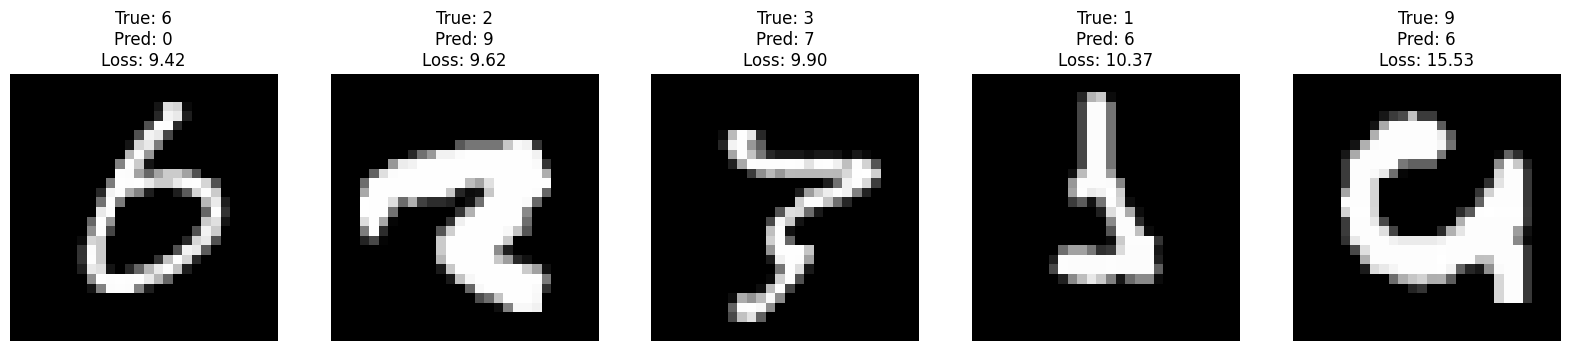

In [ ]:
top_losses_vis(hyperparameters, top_loss_indices,
                   test_images, test_preds, test_labels, test_losses)

With the confusion matrix for the test set

Accuracy for the entire test set is: 0.8436


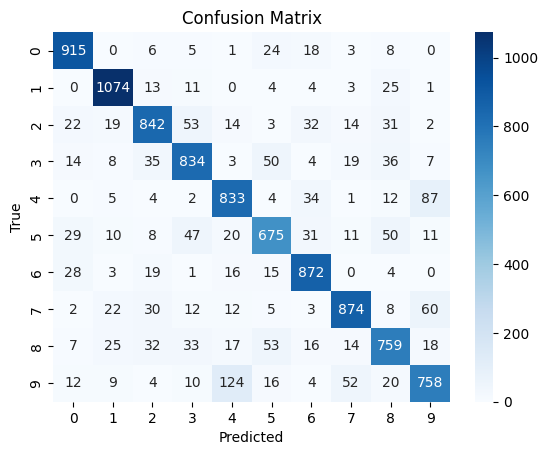

In [ ]:
print(f'Accuracy for the entire test set is: {test_acc}')
conf_mat(figSize)

# Approach \# 2: Hand-designed feature extraction and the following table data classification using the ANN

## Save the results

Save the model

In [ ]:
task.update_output_model(model_path=f'Lab_1_seed={seed}.pth')
torch.save(model.state_dict(), f'Lab_1_seed={seed}.pth')

Exception encountered while uploading [Errno 2] No such file or directory: 'mnist_mlp_model.pth'


Stop logging

In [ ]:
task.close()

# Conclusion

Enter you text here.

Please note that the conclusion is not only a declaration of the obtained results. It should also answer relevant questions related to the work, providing insights that enhance the reader's understanding, make their life a bit easier, and contribute to making the world a bit better — or at least a bit clearer.


# Questions for discussion

* Explain the architecture of the MLP model used in this lab. What are the dimensions of the input layer, hidden layers, and output layer? Why is the input size `28 * 28` for the MNIST dataset?
* What loss function is used in this lab, and why is it suitable for this task? Which optimizer is used, and what is its learning rate?
* What transformations are applied to the MNIST dataset before training? Why is normalization important, and what values are used for normalization in this lab?
* Are the models prone to overfitting? Was this possibility considered and addressed during the modeling process?
* How is accuracy calculated during the testing phase? What does the confusion matrix represent, and how can it help in evaluating the model's performance?
* What does the "Top Losses" visualization represent? How can it help in debugging or improving the model?


## Bonus Questions (Optional)
* What is the purpose of using ClearML in this lab? How does it help in managing machine learning experiments, in general?
